In [19]:
# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(0)

In [20]:
# MODEL CONSTANTS
n_realizations = 2
N = 100 # number of observations
D = 200 
pstar = 20 # number of non-zero predictors
sigma = 1 # noise parameter

# MCMC PARAMETERS
num_warmup = 500
num_samples = 1000
num_chains = 2

# TESTING
prob_1 = pstar / D
alphas = jnp.zeros(D)
alphas += (prob_1) / (1-prob_1)
# alphas = jnp.ones(D)
A_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lams = [2, 1, 1/2, 1/10, 1/100]

<h1> Generating Data </h1>

$$\begin{align*} 
y_i &\sim \sum_{j=1}^D \beta_jx_j + \epsilon_i \\
\epsilon_i &\sim N(0, \sigma^2), \;\; i = 1, ..., N
\end{align*}$$
Similarly to Piironen's toy example, We generate $100$ data realizations. Our true parameter vector $\beta^*$ has length $D=400$ and $p^*=20$ non-zero entries with some value $A \in$ $\{1, 2, ..., 10\}$. The total number of observations per realization is $n=400$.

In [21]:
def generate_data(A, sigma):
  """
  Generate synthetic data.

  Parameters:
    int dim: The dimension of the dataset
    int pstar: The number of true non-zero signals
    real A: The magnitude of true non-zero signals
    real sigma: Standard deviation of the noise
    nrep: The number of replications
  """
  X = np.random.normal(size=(N, D)) # NxD
  beta_star = np.zeros([D]) # Initialise
  beta_star[:pstar] += A   # Add signal
  Y = jnp.dot(X, beta_star) # Y = X * beta
  Y += np.random.normal(0, sigma, size=N)  # Add noise to Y
  return X, Y

<h2> Defining the Model </h2>

$$\begin{align*} 
y_i &\sim \sum_{j=1}^D \beta_jX_j + \epsilon_i \\
\beta_j &= \gamma_jA\\
\gamma_j &= \sigma \left(\frac{L_j + \log\alpha_j}{\lambda}\right) \text{  for   } j = 1, ..., D \\
L_j &= \log (U_j) - \log (1-U_j)\\
U_j &\sim \text{Uniform}(0, 1)
\end{align*}$$




Note that in order for the model to work correctly, $\alpha_i$ must be  $\in (0, \infty)$.


In addition, the shrinkage coefficient $\kappa_i = 1 - \gamma_i$ is recorded.

In [22]:
def model(alphas, lam, X=None, Y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter
    '''
    assert X.shape == (N, D), "X shape is {X.shape}. Should be (N, D)"
    assert Y.shape == (N, ), "Y.shape is {Y.shape}. Should be (N, )"
    assert alphas.shape == (D, ), "alphas.shape is {alphas.shape}. Should be (D, )"

    U = numpyro.sample("U", dist.Uniform(0, 1).expand((n_realizations, D))) #nxD
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1 - U)) #nxD
    alphas_mult = jnp.array([alphas]*n_realizations) #nxD
    assert alphas_mult.shape == (n_realizations, D), f"alphas_mult.shape is {alphas_mult.shape}. Should be ({n_realizations}, {D})"

    gammas = numpyro.deterministic("gammas", sigmoid((L + jnp.log(alphas)) / lam)) #nxD
    kappas = numpyro.deterministic("kappas", 1 - gammas) #nxD
    y_mean = jnp.dot(X, gammas.mean(axis=0)) #NxD * Dx1
    y = numpyro.sample("Y", dist.Normal(y_mean, sigma), obs=Y) #Nx1 

In [23]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 
       array y: observed data

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, progress_bar=False)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [24]:
def concrete(all_data, lam):
    '''
    Parameters:
       dict all_data: keys are integers and values are the corresponding tuple (X, Y)
       int lam: temperature coefficient
    
    Returns:
       arr mses: size (D,)
       arr kappas: length len(A_values) * D
       arr mean_gammas: size (D,)
       arr betas: size (D,)
       dict samples: keys are sampled values in the mcmc model, values are the samples
       mcmc: a Numpyro MCMC object

    '''
    kappas = []

    for A, data in all_data.items():
        X, Y = data

        mcmc = run_mcmc(model, prng_key, alphas = alphas, lam = lam, X=X, Y=Y)
        samples = mcmc.get_samples()

        mean_gammas = samples['gammas'].mean(axis=0) # mean across all samples in one mcmc run
        mean_gammas = mean_gammas.mean(axis=0) # mean across N
        assert mean_gammas.shape == (D, ), f"Shape is {mean_gammas.shape}. Should be (D, )"

        kappas.extend(samples['kappas'])
        
    return kappas, mean_gammas, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [25]:
all_mses = dict()
mean_mses = dict()
all_kappas = dict()
mean_betas = dict()
mean_gammas = dict()
all_mcmc_runs = []
all_data = {}

for A in A_values:
    all_data[A] = generate_data(A=A, sigma=1) 

for lam in lams:
    kappas, gammas, all_samples, mcmc = concrete(all_data, lam=lam)
    all_mses[lam] = [0]*(len(A_values)+1)
    mean_betas[lam] = [0]*(len(A_values)+1)

    for A in A_values:
        beta_star = np.zeros(D)
        beta_star[:pstar] = A
        estimated_betas = gammas * beta_star
        mses = (estimated_betas-beta_star)**2

        all_mses[lam][A] = np.array(mses)
        all_kappas[lam] = kappas
        mean_gammas[lam] = gammas
        mean_betas[lam][A] = estimated_betas
        all_mcmc_runs.append(mcmc)
        print('done')
    


/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_15297/4141366965.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, progress_bar=False)
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_15297/4141366965.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, 

done
done
done
done
done
done
done
done
done
done


/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_15297/4141366965.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, progress_bar=False)
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_15297/4141366965.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, 

done
done
done
done
done
done
done
done
done
done


/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_15297/4141366965.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, progress_bar=False)
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_15297/4141366965.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, 

done
done
done
done
done
done
done
done
done
done


/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_15297/4141366965.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, progress_bar=False)
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_15297/4141366965.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, 

done
done
done
done
done
done
done
done
done
done


/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_15297/4141366965.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, progress_bar=False)
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_15297/4141366965.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, 

done
done
done
done
done
done
done
done
done
done


The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [26]:
for mcmc in all_mcmc_runs:
    mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    U[0,0]      1.00      0.00      1.00      1.00      1.00    737.71      1.00
    U[0,1]      1.00      0.00      1.00      1.00      1.00     12.45      1.00
    U[0,2]      1.00      0.00      1.00      1.00      1.00      8.00      1.00
    U[0,3]      1.00      0.00      1.00      1.00      1.00   1710.52      1.00
    U[0,4]      1.00      0.00      1.00      1.00      1.00   2437.28      1.00
    U[0,5]      1.00      0.00      1.00      1.00      1.00   1332.94      1.00
    U[0,6]      1.00      0.00      1.00      1.00      1.00      6.00      1.00
    U[0,7]      1.00      0.00      1.00      1.00      1.00     14.24      1.00
    U[0,8]      1.00      0.00      1.00      1.00      1.00   1976.74      1.00
    U[0,9]      1.00      0.00      1.00      1.00      1.00      6.53      1.00
   U[0,10]      1.00      0.00      1.00      1.00      1.00      6.82      1.00
   U[0,11]      1.00      0

<h1> Results </h1>

Text(0.5, 0, 'Entry #')

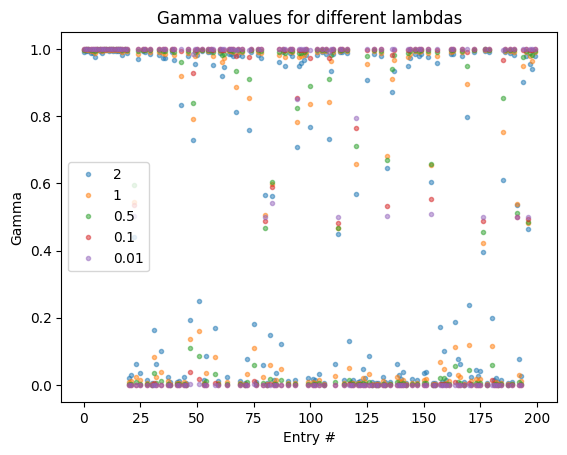

In [27]:
for gamma in mean_gammas:
    plt.plot(range(D), mean_gammas[gamma], '.', label=gamma, alpha=0.5)
plt.legend()
plt.title("Gamma values for different lambdas")
plt.ylabel("Gamma")
plt.xlabel("Entry #")

Text(0.5, 0.98, 'True Beta vs. Estimated Beta')

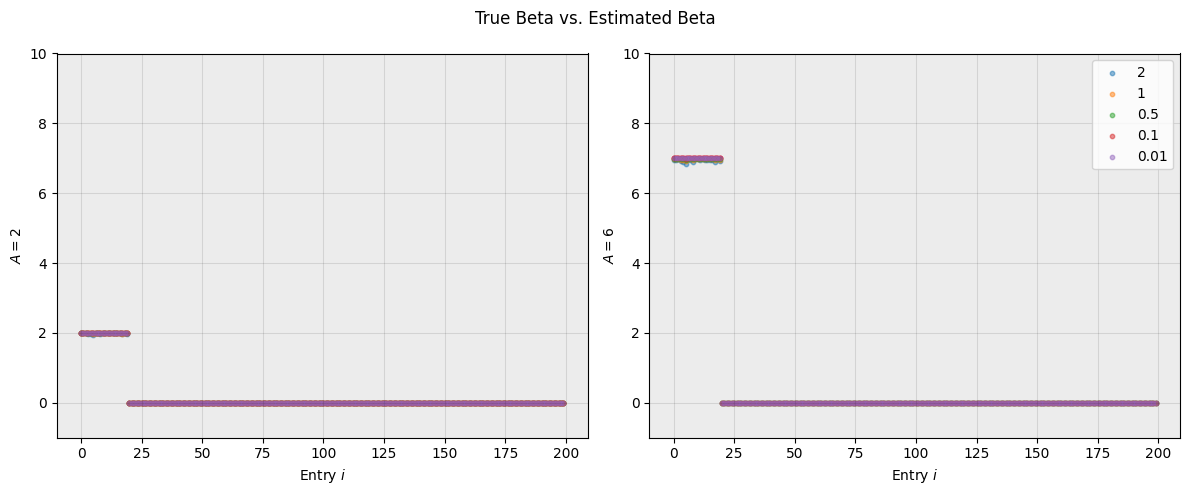

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), layout="tight")
for ax in [ax1, ax2]: 
    ax.set_facecolor("#ECECEC") # set graph background color to grey
    ax.grid(visible=True, color="black", alpha=0.1) # add grid lines

# resetting y-axis range so that the graphs line up
ax2.set_ylim([-1, 10]) 
ax1.set_ylim([-1, 10])

beta_star_7 = np.zeros(D)
beta_star_7[:pstar] = 7
beta_star_2 = np.zeros(D)
beta_star_2[:pstar] = 2

ax1.scatter(range(D), beta_star_2, color='red', s=10) # plot actual betas
ax2.scatter(range(20), beta_star_7[:20], color='red', s=10) 
for lam in lams:
    ax1.scatter(range(D), mean_betas[lam][2], s=10, alpha=0.5, label=lam)
    ax2.scatter(range(D), mean_betas[lam][7], s=10, alpha=0.5, label=lam)

# add labels to graph
ax1.set(ylabel=r'$A=2$', xlabel=r'Entry $i$')
ax2.set(ylabel=r'$A=6$', xlabel=r'Entry $i$')
plt.legend()
fig.suptitle("True Beta vs. Estimated Beta")


In [29]:
mean_gammas[1][0:20]
mean_gammas[1][0:20] * beta_star_7[:20]
print(mean_betas[1][7][:20])
mean_gammas[1][0:20] * beta_star_7[:20]

[6.97157   6.9816265 6.983813  6.9603686 6.9534655 6.918404  6.985237
 6.981479  6.953619  6.985246  6.9863806 6.981922  6.9847703 6.9798474
 6.9809766 6.9807973 6.980839  6.94266   6.9868846 6.9616795]


Array([6.97157  , 6.9816265, 6.983813 , 6.9603686, 6.9534655, 6.918404 ,
       6.985237 , 6.981479 , 6.953619 , 6.985246 , 6.9863806, 6.981922 ,
       6.9847703, 6.9798474, 6.9809766, 6.9807973, 6.980839 , 6.94266  ,
       6.9868846, 6.9616795], dtype=float32)

In [30]:
for lam in lams:
    mean_mses[lam] = dict()
    for A in A_values:
        mean_mses[lam][A] = all_mses[lam][A].mean()
mean_mses[1]

{1: 2.2355391e-06,
 2: 8.9421565e-06,
 3: 2.0119876e-05,
 4: 3.5768626e-05,
 5: 5.588849e-05,
 6: 8.0479505e-05,
 7: 0.00010954117,
 8: 0.0001430745,
 9: 0.00018107813,
 10: 0.00022355396}

Text(0.5, 1.0, 'Mean Squared Error for Different Lambda Values')

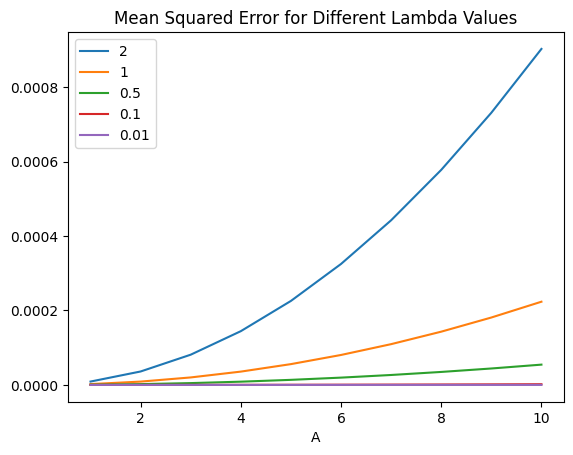

In [31]:

for lam in lams:
    plt.plot(mean_mses[lam].keys(), mean_mses[lam].values(), label=f'{lam}')

ax = plt.gca()
plt.legend()
plt.xlabel("A")
plt.title("Mean Squared Error for Different Lambda Values")

As the value of $\lambda$ decreases, the distribution of $\kappa$ values becomes more concentrated around $0$ and $1$.

Text(0.5, 1.0, 'Kappa values for different lambdas')

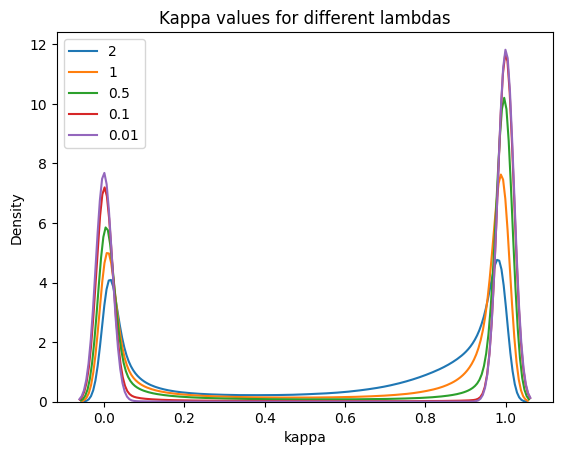

In [32]:
for lam in lams:
    all_kappas[lam] = np.ndarray.flatten(np.array(all_kappas[lam]))
    sns.kdeplot(all_kappas[lam], label=f'{lam}')
plt.legend()
plt.xlabel("kappa")
plt.title("Kappa values for different lambdas")